## Ch9 study

The ominuous "ch9 stuff". The ninth channel (so tecnnically ch8 if we start counting from zero) carries a sine wave, which is supposed to be the same accross all reacoutboards and should allow to sync the local 
timestamps by knowing the phase of the sine wave. The since wave oscillates with 25MHz.



In [1]:
print (512e-9/(1/25e6)) # expected periods

12.8
1.2229299363057327


In [1]:
import gaps_online as go
import charmingbeauty as cb
import rust_dataclasses as rd
import charmingbeauty.layout as lo
import tqdm
import re
#import HErmes.fitting.model as m
#import dashi as d
#d.visual()

from glob import glob
from pathlib import Path
from copy import deepcopy as copy

In [2]:
tofevents = []
files = [glob(f'/data0/gaps/ucla-teststand/16/run_16_{k}*')[0] for k in range(10,20)]

for fname in tqdm.tqdm(files):
    data = go.tof.get_tofpackets(fname, filter=go.cxx_api.PacketType.TofEvent)
    evts = [go.cxx_api.TofEvent.from_tofpacket(k) for k in data]
    tofevents.extend(evts)
print (len(tofevents))

IndexError: list index out of range

In [4]:
#cali = go.cxx_api.RBCalibration.from_califile('/data0/gaps/nevis/calib/latest/RB02_2024_01_26-07_48_45.cali.tof.gaps')
c37 = go.cxx_api.RBCalibration.from_califile('/data0/gaps/ucla-teststand/calib-unknown/rb_37.cali.tof.gaps')
c47 = go.cxx_api.RBCalibration.from_califile('/data0/gaps/ucla-teststand/calib-unknown/rb_47.cali.tof.gaps')
c48 = go.cxx_api.RBCalibration.from_califile('/data0/gaps/ucla-teststand/calib-unknown/rb_48.cali.tof.gaps')
c49 = go.cxx_api.RBCalibration.from_califile('/data0/gaps/ucla-teststand/calib-unknown/rb_49.cali.tof.gaps')
calis = {37 : c37, 47 : c47, 48: c48, 49 : c49}

[info] [calibration.cxx - from_bytestream:367] [2024-01-30 01:34:58] -- Decoding 1000 VCAL data events...
[info] [calibration.cxx - from_bytestream:373] [2024-01-30 01:34:58] -- Decoding 999 TCAL data events...
[info] [calibration.cxx - from_bytestream:367] [2024-01-30 01:34:58] -- Decoding 1000 VCAL data events...
[info] [calibration.cxx - from_bytestream:373] [2024-01-30 01:34:58] -- Decoding 997 TCAL data events...
[info] [calibration.cxx - from_bytestream:367] [2024-01-30 01:34:58] -- Decoding 1000 VCAL data events...
[info] [calibration.cxx - from_bytestream:373] [2024-01-30 01:34:58] -- Decoding 1000 TCAL data events...
[info] [calibration.cxx - from_bytestream:367] [2024-01-30 01:34:58] -- Decoding 1000 VCAL data events...
[info] [calibration.cxx - from_bytestream:373] [2024-01-30 01:34:58] -- Decoding 996 TCAL data events...


In [32]:
ev  = tofevents[0]
rbs = [47, 48, 49, 37]
delta_ts = {k : [] for k in rbs}
ts       = {k : [] for k in rbs}
z_pks    = {k : [] for k in rbs}
gaps_pks = {k : [] for k in rbs}
pk0      = {k : [] for k in rbs}
pk0      = {k : [] for k in rbs}
bl       = {k : [] for k in rbs}
for ev in tqdm.tqdm(tofevents):
    if len(ev.rbevents) != 4:
        continue
    for rb in ev.get_rbids():
        rb_event = ev.get_rbevent(rb)
        
        if rb_event.status == go.cxx_api.EventStatus.IncompleteReadout:
            continue
        volts   = calis[rb].voltages(rb_event)[0]
        times   = calis[rb].nanoseconds(rb_event)[0]
        this_bl = rb_event.calc_baseline(volts, 10, 50)
        bl[rb].append(this_bl)
        volts -= this_bl
        #print (times)
        gpk   = go.rust_api.find_peaks(volts, times, 100, 100, 3, 10, 5)
        if len(gpk) > 0:
            cfd = go.rust_api.cfd_simple(volts, times, 0.2,gpk[0][0], gpk[0][1])
            pk0[rb].append(cfd)
        else:
            pk0[rb].append(np.nan)
        # lag = window size of previous window, 
        # influence -> 0 means previous peak has no impact on the next
        zpk   = go.rust_api.find_peaks_zscore(volts, times, 100, 100, 50, 10, 0)
        gaps_pks[rb].append(gpk)
        z_pks[rb].append(zpk)
        #print (gpk)
        #print (zpk)
        #p.plot(volts)
        #raise
        #print (volts)
        #raise
        #times = calis[rb].nanoseconds(rb_event)[0]
        
        pks = go.rust_api
        delta_ts[rb].append(rb_event.header.get_timestamp48() - ev.mt_event.timestamp)
        ts[rb].append(ev.get_rbevent(rb).header.get_timestamp48())
#print (ev)
#print (ev.get_rbids())

100%|█████████████████████████████████████████████████████| 97903/97903 [00:50<00:00, 1944.55it/s]


Text(0, 1, 'events')

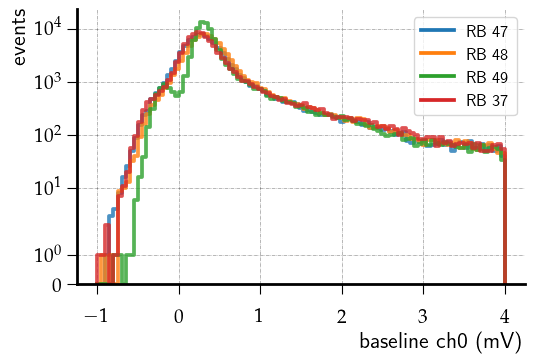

In [7]:
%matplotlib inline
fig = p.figure(figsize=lo.FIGSIZE_A4_LANDSCAPE)
ax  = fig.gca()

colors = 'r', 'b', 'c', 'm'
bins = np.linspace(-1,4,100)
for rb_id in bl.keys():
    h = d.histfactory.hist1d(bl[rb_id],bins)
    h.line(filled=False, alpha=0.8, label=f'RB {rb_id}')
    #h.line(filled=False)
ax.legend()
ax.set_yscale('symlog')
ax.set_ylim(bottom=0)
ax.set_xlabel('baseline ch0 (mV)', loc='right')
ax.set_ylabel('events', loc='top')

Text(0, 1, 'events')

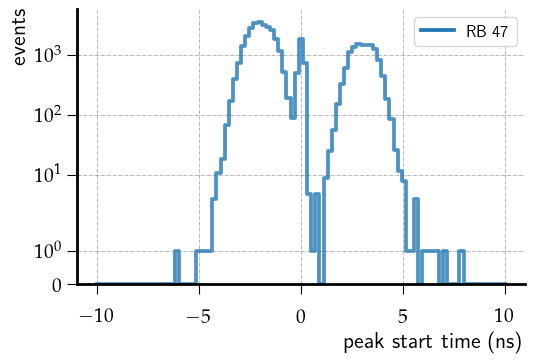

In [38]:
%matplotlib inline
fig = p.figure(figsize=lo.FIGSIZE_A4_LANDSCAPE)
ax  = fig.gca()

colors = 'r', 'b', 'c', 'm'
bins = np.linspace(-1,4,100)
bins = np.arange(0.5,10.5,0.5)
bins = 100
bins = np.linspace(-10,10,100)
data = np.array(pk0[48]) - np.array(pk0[47])
#data = np.sqrt(data**2)
for rb_id in gaps_pks.keys():
    #print (gaps_pks[rb_id])
    #print (z_pks[rb_id])
    #data = [len(k) for k in gaps_pks[rb_id]]
    #data = [len(k) for k in z_pks[rb_id]]
    #data = [k[0][0] for k in gaps_pks[rb_id] if len (k) > 0]
    #data = pk0[rb_id]
    
    h = d.histfactory.hist1d(data,bins)
    h.line(filled=False, alpha=0.8, label=f'RB {rb_id}')
    break
    #h.line(filled=False)
ax.legend()
ax.set_yscale('symlog')
ax.set_ylim(bottom=0)
ax.set_xlabel('peak start time (ns)', loc='right')
ax.set_ylabel('events', loc='top')

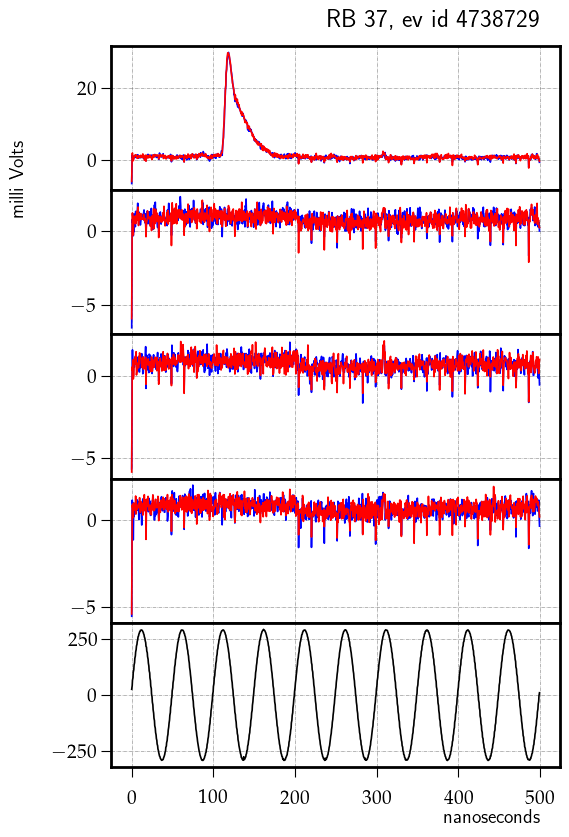

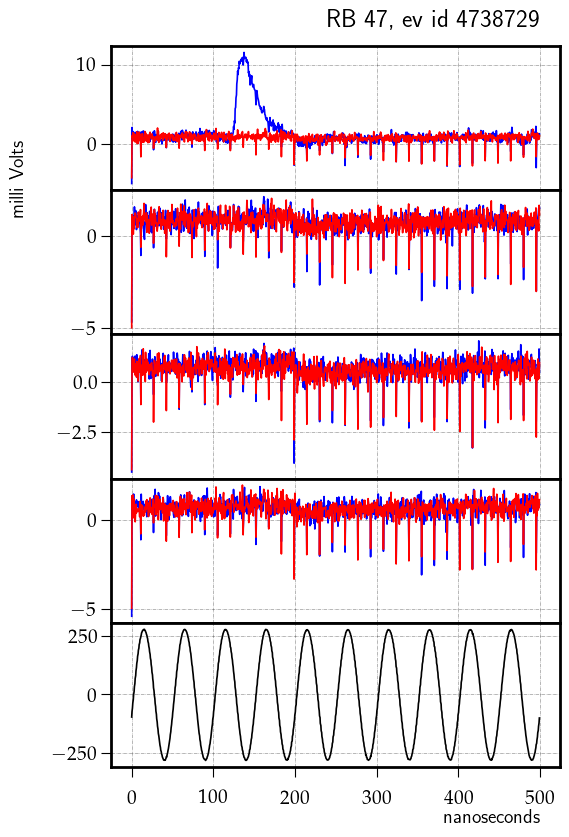

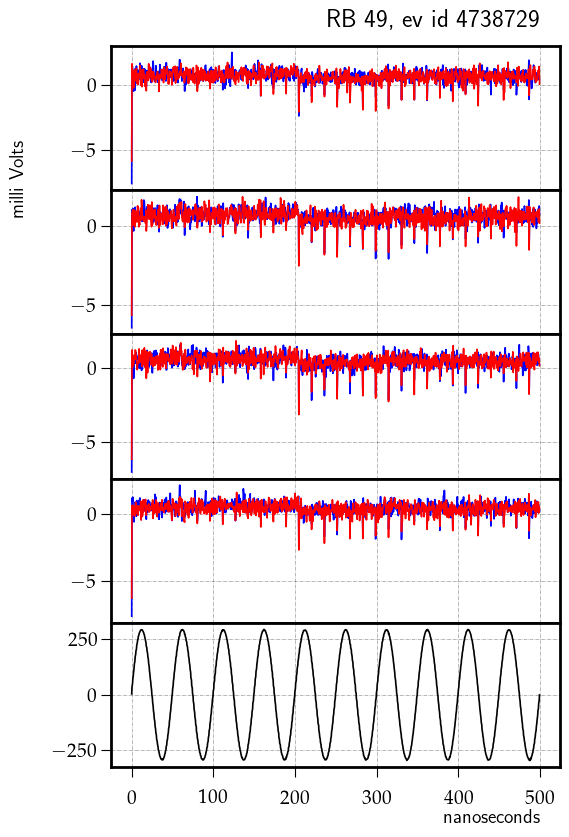

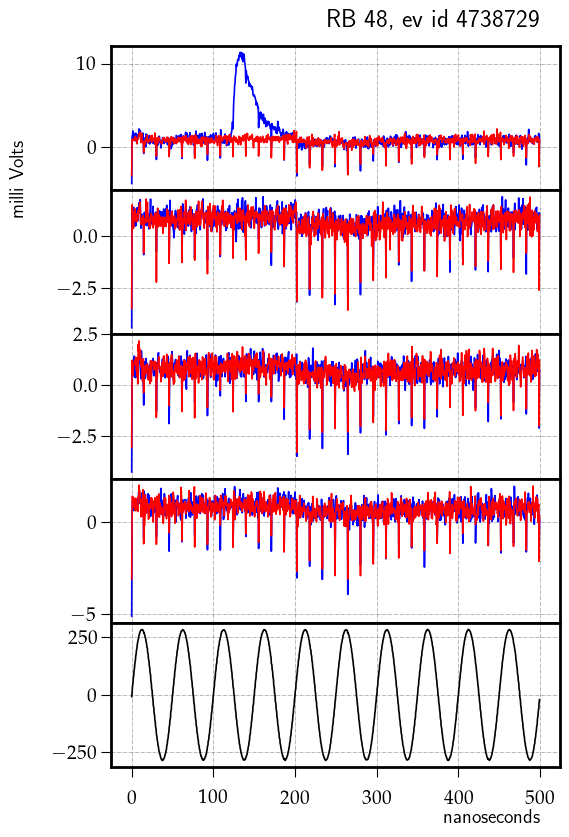

In [33]:
event = tofevents[15]
for rb_id in event.get_rbids():
    rb_event = event.get_rbevent(rb_id)
    rb_event.plot(calib=calis[rb_id])

In [1]:
print (bl)

NameError: name 'bl' is not defined

In [26]:
#go.rust_api.cfd_simple?
go.rust_api.find_peaks_zscore?
#go.rust_api.find_peaks?

Signature:
go.rust_api.find_peaks_zscore(
    voltages,
    nanoseconds,
    start_time,
    window_size,
    lag,
    threshold,
    influence,
)
Docstring: <no docstring>
Type:      builtin_function_or_method

47 96668
48 96668
49 96668
37 96668
648384106419 648384106418


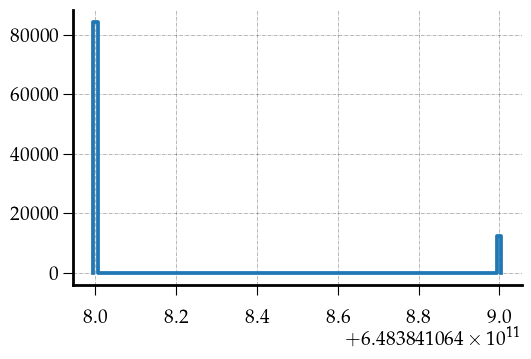

In [12]:
%matplotlib inline
for k in delta_ts:
    print (k, len(delta_ts[k]))

fig = p.figure(figsize=lo.FIGSIZE_A4_LANDSCAPE)
ax  = fig.gca()
for k in ts:
    ts[k] = np.array(ts[k])
bins = np.linspace(0,0.1,100)
bins = 100
delta = ts[48] - ts[49]
print(max(delta), min(delta))
h4847 = d.factory.hist1d(delta,bins)
h4847.line()
#for rbid in rbs:
#    h = d.factory.hist1d(delta_ts[rbid],100)
#    h.line()
#    break

p.show()
    

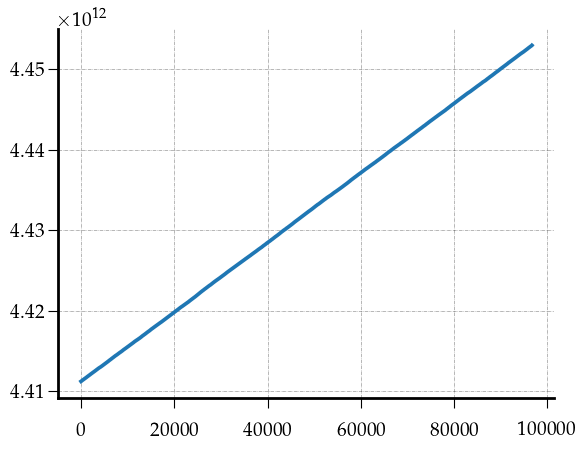

In [11]:
p.plot(ts[37])

In [10]:
print (ev.mt_event)

<MasterTriggerEvent : [N LTBS 20]
  event_id      : 4640782
  timestamp     : 2818102785
  tiu_timestamp : 2795695625
  tiu_gps_32    : 132270
  tiu_gps_16    : 0
  n_paddles     : 0
  crc           : 0
  broken        : 1
  valid         : 0
 == == LTB HITS DSI/J/CH => [RB_ID CH] == ==
	 DSI/J 1/2 1 => ?
>


In [8]:
rbev = ev.rbevents[0]
print (rbev)
rbev.header.get_timestamp48()

<RBEvent
  status    : <EventStatus: Unknown>
<RBEventHeader
  rb id          47
  event id       4640782
  is locked      1
  is locked (1s) 1
  lost trigger   0
  event fragment 0
  channel mask   511
  |-> channels    0  1  2  3  4  5  6  7  8 
  stop cell      439
  ** online ch9 fit amp, freq, phase
    AMP 3.717861  FREQ 0.900130  PHASE 7.734646
  timestamp32    1368017443
  timestamp16    1016
  |->timestamp48 4365054790179
  FPGA temp [C]  57.829674>
 -- -- adc -- --
 0: ..4950 4645 .. ..
 1: ..4858 4656 .. ..
 2: ..4630 4489 .. ..
 3: ..4610 4499 .. ..
 4: ..4679 4578 .. ..
 5: ..4637 4614 .. ..
 6: ..4483 4631 .. ..
 7: ..4526 4715 .. ..
 8: ..2109 1975 .. ..
 -- no hits!>


4365054790179

In [27]:
data = go.cxx_api.get_tofpackets('/data0/gaps/nevis/54/Run54_10.2024_01_26-02_29_27.gaps.tof', filter=go.cxx_api.PacketType.TofEvent)


No calibration given! Will plot adc values!


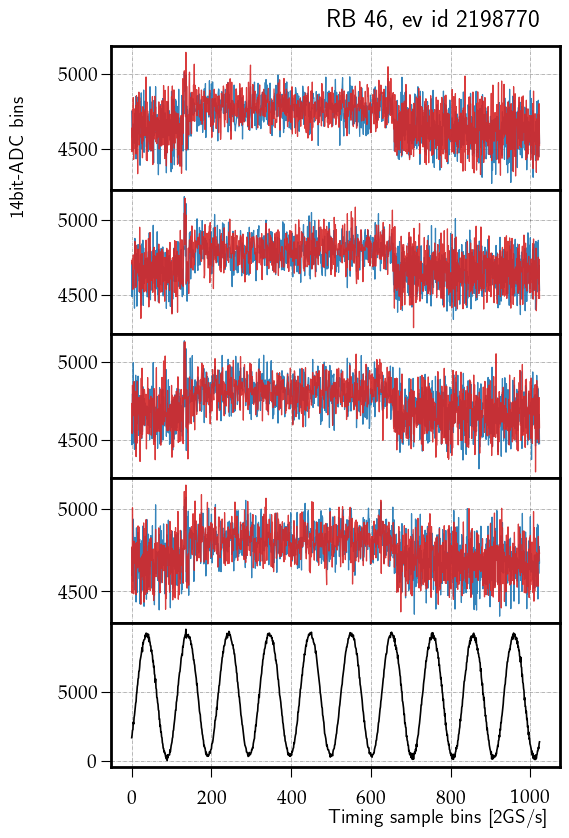

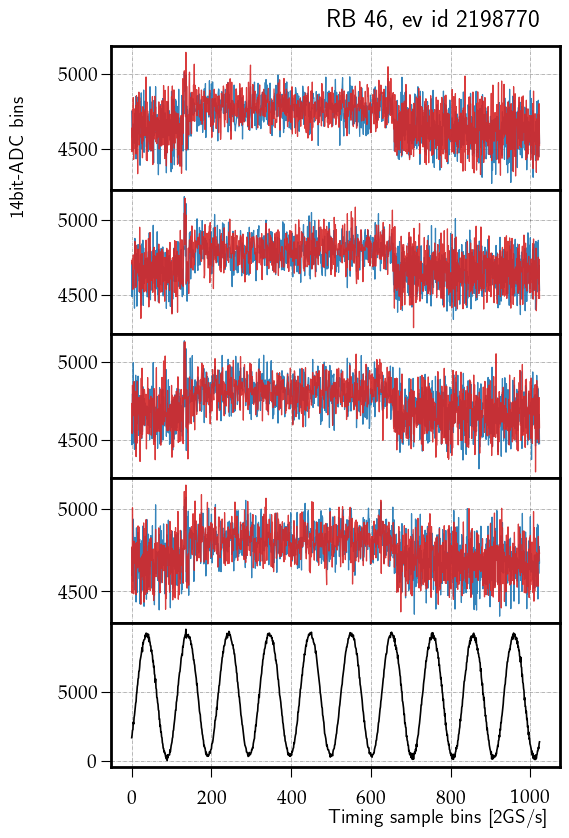

In [30]:
go.cxx_api.TofEvent.from_tofpacket(data[100]).rbevents[0].plot()